In [1]:
import findspark
findspark.init()

In [2]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from pyspark.sql import Row
import pyspark.sql.functions as f

import pyspark.sql.types as t

import pyspark.ml.feature as feat

import numpy as np
import pandas as pd

# Pipeline
from pyspark.ml import Pipeline, PipelineModel

# Machine learning
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Cross validation 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [42]:
import squarify
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [4]:
# import os
# import sys

# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# About Dataset
Build a clustering model for Customer Segmentation.

In [5]:
SparkContext.setSystemProperty(key='spark.hadoop.dfs.client.use.datanode.hostname',value='true')

In [6]:
sc =SparkContext()

In [7]:
sc.setLogLevel("ERROR")

In [8]:
spark = SparkSession(sc)

In [9]:
df = spark.read.csv('../DATA/rfm_data.csv',inferSchema=True,header=True)

In [10]:
df.show(5)

+----------+-------+---------+--------+---+---+---+-------+---------+--------+
|CustomerID|recency|frequency|monetary|  R|  F|  M|rfm_seg|rfm_score|   label|
+----------+-------+---------+--------+---+---+---+-------+---------+--------+
|     12346|    325|        1| 77183.6|  1|  1|  4|    114|        6|    rich|
|     12347|      1|        7|  4310.0|  4|  4|  4|    444|       12|     VIP|
|     12348|     74|        4| 1797.24|  2|  3|  4|    234|        9|    rich|
|     12349|     18|        1| 1757.55|  4|  1|  4|    414|        9|   other|
|     12350|    309|        1|   334.4|  1|  1|  2|    112|        4|inactive|
+----------+-------+---------+--------+---+---+---+-------+---------+--------+
only showing top 5 rows



# Overview

In [11]:
df.show(1,vertical=False,truncate=True)
df.printSchema()
print(f'There are {df.count()} rows and {len(df.columns)} columns in dataframe')

+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|CustomerID|recency|frequency|monetary|  R|  F|  M|rfm_seg|rfm_score|label|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|     12346|    325|        1| 77183.6|  1|  1|  4|    114|        6| rich|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+
only showing top 1 row

root
 |-- CustomerID: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: integer (nullable = true)
 |-- monetary: double (nullable = true)
 |-- R: integer (nullable = true)
 |-- F: integer (nullable = true)
 |-- M: integer (nullable = true)
 |-- rfm_seg: integer (nullable = true)
 |-- rfm_score: integer (nullable = true)
 |-- label: string (nullable = true)

There are 5766 rows and 10 columns in dataframe


## check null

In [12]:
df.select([f.count(f.when(f.isnan(c), c)).alias(c) for c in df.columns]).show()

+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|CustomerID|recency|frequency|monetary|  R|  F|  M|rfm_seg|rfm_score|label|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|         0|      0|        0|       0|  0|  0|  0|      0|        0|    0|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+



In [13]:
df.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|CustomerID|recency|frequency|monetary|  R|  F|  M|rfm_seg|rfm_score|label|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|         0|      0|        0|       0|  0|  0|  0|      0|        0|    0|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+



## Descirble data

In [14]:
cat_col = ['R','F','M','rfm_seg','label']
cat_col

['R', 'F', 'M', 'rfm_seg', 'label']

In [15]:
numeric_col = [k for k,v in dict(df.dtypes).items() if not (v=='string' or v=='timestamp') and not k in cat_col]
#numeric_col = numeric_col[2:] 
numeric_col

['recency', 'frequency', 'monetary', 'rfm_score']

In [16]:
df.select(numeric_col).describe().show()

+-------+------------------+------------------+----------------+------------------+
|summary|           recency|         frequency|        monetary|         rfm_score|
+-------+------------------+------------------+----------------+------------------+
|  count|              5766|              5766|            5766|              5766|
|   mean|116.50693721817551|3.4616718695802984|1849.92794658342|               7.5|
| stddev|111.29927870457249| 6.824640696687705|7919.02686104613|2.7233690425446904|
|    min|                 0|                 1|            0.42|                 3|
|    max|               373|               209|       280206.02|                12|
+-------+------------------+------------------+----------------+------------------+



## Category data

### Check distinct values

In [17]:
df.select([f.count_distinct(c).alias(c) for c in df.columns if c not in numeric_col]).show()

+----------+---+---+---+-------+-----+
|CustomerID|  R|  F|  M|rfm_seg|label|
+----------+---+---+---+-------+-----+
|      5766|  4|  4|  4|     63|    8|
+----------+---+---+---+-------+-----+



- Remove some columns is not appropriate for model: `CustomerID` because it can cause **the curse of dimensionality**

In [18]:
df_final = df.drop('CustomerID')

### Check top5 disticnt value count of each category columns in df 

In [19]:
for col in cat_col:
    (df.groupby(col).count()
     .withColumn('Normalize',(f.col('count')/df_final.count()))
     .orderBy(f.col('count').desc())
     .show(5,vertical=False,truncate=False))

+---+-----+------------------+
|R  |count|Normalize         |
+---+-----+------------------+
|1  |1442 |0.2500867152271939|
|4  |1442 |0.2500867152271939|
|3  |1441 |0.2499132847728061|
|2  |1441 |0.2499132847728061|
+---+-----+------------------+

+---+-----+------------------+
|F  |count|Normalize         |
+---+-----+------------------+
|1  |1442 |0.2500867152271939|
|4  |1442 |0.2500867152271939|
|3  |1441 |0.2499132847728061|
|2  |1441 |0.2499132847728061|
+---+-----+------------------+

+---+-----+------------------+
|M  |count|Normalize         |
+---+-----+------------------+
|1  |1442 |0.2500867152271939|
|4  |1442 |0.2500867152271939|
|3  |1441 |0.2499132847728061|
|2  |1441 |0.2499132847728061|
+---+-----+------------------+

+-------+-----+-------------------+
|rfm_seg|count|Normalize          |
+-------+-----+-------------------+
|444    |585  |0.10145681581685743|
|121    |290  |0.05029483177245924|
|111    |281  |0.04873395768296913|
|344    |257  |0.04457162677766216|
|

In [20]:
df_final.show()

+-------+---------+--------+---+---+---+-------+---------+---------+
|recency|frequency|monetary|  R|  F|  M|rfm_seg|rfm_score|    label|
+-------+---------+--------+---+---+---+-------+---------+---------+
|    325|        1| 77183.6|  1|  1|  4|    114|        6|     rich|
|      1|        7|  4310.0|  4|  4|  4|    444|       12|      VIP|
|     74|        4| 1797.24|  2|  3|  4|    234|        9|     rich|
|     18|        1| 1757.55|  4|  1|  4|    414|        9|    other|
|    309|        1|   334.4|  1|  1|  2|    112|        4| inactive|
|     35|        8| 2506.04|  3|  4|  4|    344|       11|      VIP|
|    203|        1|    89.0|  1|  1|  1|    111|        3| inactive|
|    231|        1|  1079.4|  1|  1|  3|    113|        5|    other|
|    213|        1|   459.4|  1|  1|  2|    112|        4| inactive|
|     22|        3| 2811.43|  4|  3|  4|    434|       11|      VIP|
|     32|        1| 6207.67|  3|  1|  4|    314|        8|    other|
|      1|        2| 1168.06|  4|  

## Numeric data

## Check skewness

In [21]:
df_final.select([f.skewness(c) for c in numeric_col]).show()

+------------------+-------------------+------------------+-------------------+
| skewness(recency)|skewness(frequency)|skewness(monetary)|skewness(rfm_score)|
+------------------+-------------------+------------------+-------------------+
|0.8125804966719041| 13.353943773741968|21.428859876655775|0.14789449526230464|
+------------------+-------------------+------------------+-------------------+



There is a high skewness => use MinMax scaler

## Coeffiecient Correlation 

C:\ProgramData\Anaconda3\envs\env39\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


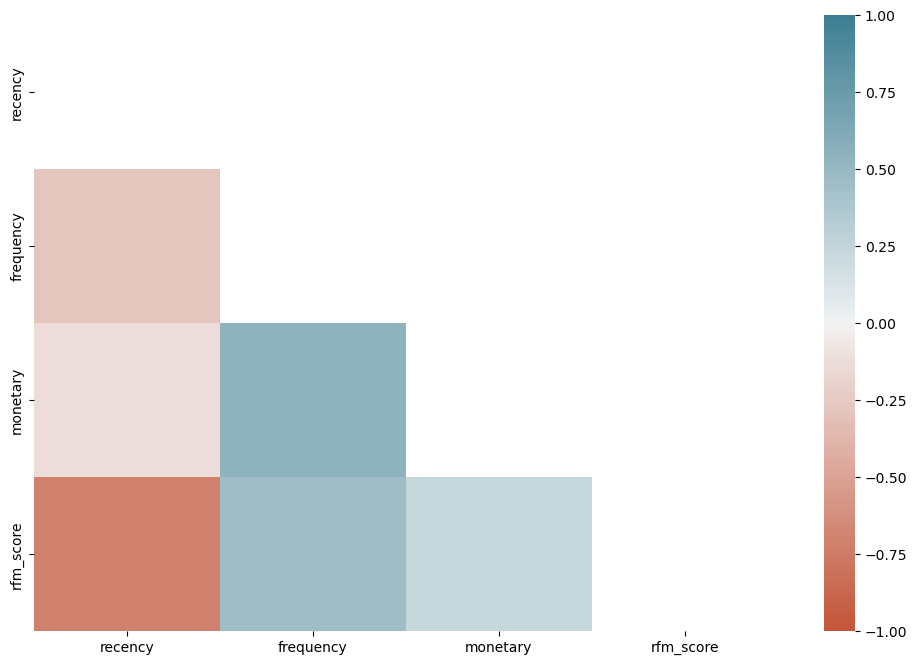

In [22]:
corr = df_final.select([c for c in df_final.columns if c not in cat_col]).toPandas().select_dtypes('number').corr()
mask_ut=np.triu(np.ones(corr.shape)).astype(bool)
plt.figure(figsize=(12,8))
sns.heatmap(corr,
            annot=True,
            vmin=-1,center=0,vmax=1,
            cmap=sns.diverging_palette(20, 220, n=200),
            mask=mask_ut)
plt.show()

# Preprocessing

In [23]:
features = ['recency','frequency','monetary','rfm_score'] 
cluster_df = df_final.select(features)
cluster_df.show(3)

+-------+---------+--------+---------+
|recency|frequency|monetary|rfm_score|
+-------+---------+--------+---------+
|    325|        1| 77183.6|        6|
|      1|        7|  4310.0|       12|
|     74|        4| 1797.24|        9|
+-------+---------+--------+---------+
only showing top 3 rows



In [24]:
cluster_df = feat.VectorAssembler(inputCols=cluster_df.columns,outputCol='features').transform(cluster_df)
cluster_df.show(3)

+-------+---------+--------+---------+--------------------+
|recency|frequency|monetary|rfm_score|            features|
+-------+---------+--------+---------+--------------------+
|    325|        1| 77183.6|        6|[325.0,1.0,77183....|
|      1|        7|  4310.0|       12|[1.0,7.0,4310.0,1...|
|     74|        4| 1797.24|        9|[74.0,4.0,1797.24...|
+-------+---------+--------+---------+--------------------+
only showing top 3 rows



In [25]:
scaler_model = feat.MinMaxScaler(inputCol='features', 
                                 min=1,  
                                 max=10, 
                                 outputCol='scale').fit(cluster_df)

In [26]:
cluster_df = scaler_model.transform(cluster_df)

In [27]:
cluster_df.show(3,False)

+-------+---------+--------+---------+-----------------------+---------------------------------------------------------------+
|recency|frequency|monetary|rfm_score|features               |scale                                                          |
+-------+---------+--------+---------+-----------------------+---------------------------------------------------------------+
|325    |1        |77183.6 |6        |[325.0,1.0,77183.6,6.0]|[8.841823056300267,1.0,3.4790675846592642,4.0]                 |
|1      |7        |4310.0  |12       |[1.0,7.0,4310.0,12.0]  |[1.0241286863270778,1.2596153846153846,1.1384205740356368,10.0]|
|74     |4        |1797.24 |9        |[74.0,4.0,1797.24,9.0] |[2.785522788203753,1.1298076923076923,1.0577125510696432,7.0]  |
+-------+---------+--------+---------+-----------------------+---------------------------------------------------------------+
only showing top 3 rows



# Evaluation:

In [28]:
# trains a k-means model
k_list = []
silhouette_ls = list()
inertia_ls = list()
for k in range(2,11):
    kmeans_model = KMeans(featuresCol='scale',maxIter=30, k=k, seed=42).fit(cluster_df)
    k_list.append(k)
    
    # prediction
    pred = kmeans_model.transform(cluster_df)

    # Get inertia value (within-cluster sum of squares)
    inertia = kmeans_model.summary.trainingCost
    inertia_ls.append(inertia)

    # evaluate clustering by computting silhoutte score
    eval_ = ClusteringEvaluator(predictionCol='prediction')
    sil = eval_.evaluate(pred)
    silhouette_ls.append(sil)
    
    print(f'With k = {k} - Silhouette = {sil:.3f} - Inertia value: {inertia:.3f} \n')

With k = 2 - Silhouette = -0.156 - Inertia value: 32005.076 

With k = 3 - Silhouette = -0.264 - Inertia value: 17106.413 

With k = 4 - Silhouette = -0.358 - Inertia value: 13591.516 

With k = 5 - Silhouette = -0.618 - Inertia value: 11972.145 

With k = 6 - Silhouette = -0.474 - Inertia value: 8823.154 

With k = 7 - Silhouette = -0.444 - Inertia value: 7041.612 

With k = 8 - Silhouette = -0.405 - Inertia value: 6350.329 

With k = 9 - Silhouette = -0.488 - Inertia value: 5291.273 

With k = 10 - Silhouette = -0.489 - Inertia value: 4894.225 



- As the evaluation report, we should use:
    - With k = 6 - Silhouette = -0.474 - Inertia value: 8823.154 

    - With k = 7 - Silhouette = -0.444 - Inertia value: 7041.612

## Visualization

In [29]:
score_df = pd.DataFrame(data={'cluster':k_list,'sil_score':silhouette_ls, 'inertia_errors':inertia_ls})
score_df.head()

,cluster,sil_score,inertia_errors
0,2,-0.156092,32005.076400
1,3,-0.264195,17106.412517
2,4,-0.357624,13591.515776
3,5,-0.618078,11972.144819
4,6,-0.474281,8823.153546


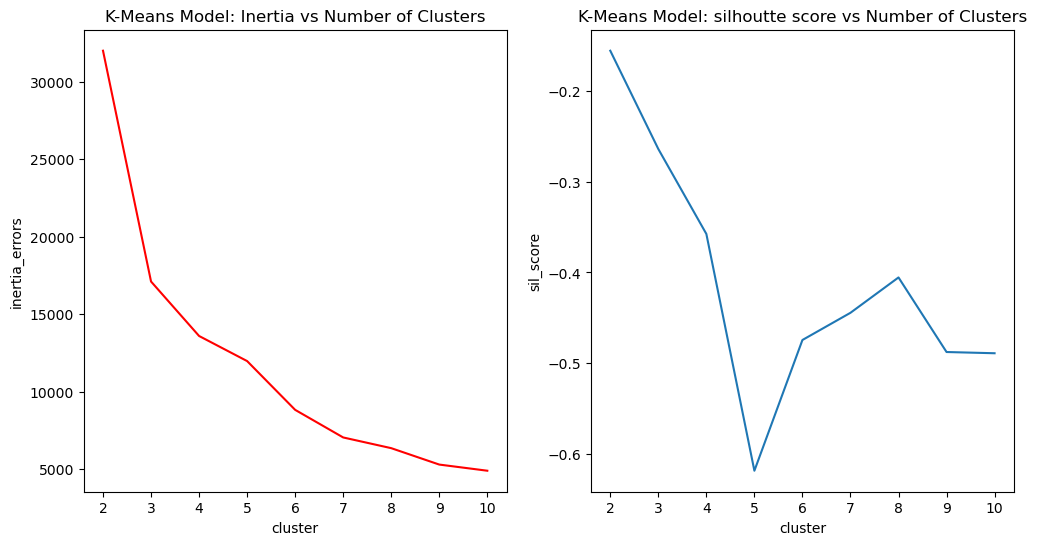

In [30]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
# Create line plot of `inertia_errors` vs `n_clusters`
sns.lineplot(data=score_df,
              x='cluster', 
              y='inertia_errors',ax=ax[0],
             color='r'
)
sns.lineplot(data=score_df,
              x='cluster', 
              y='sil_score',ax=ax[1]
)
# fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
# fig.show()
ax[0].set_title('K-Means Model: Inertia vs Number of Clusters')
ax[1].set_title('K-Means Model: silhoutte score vs Number of Clusters')
plt.show()

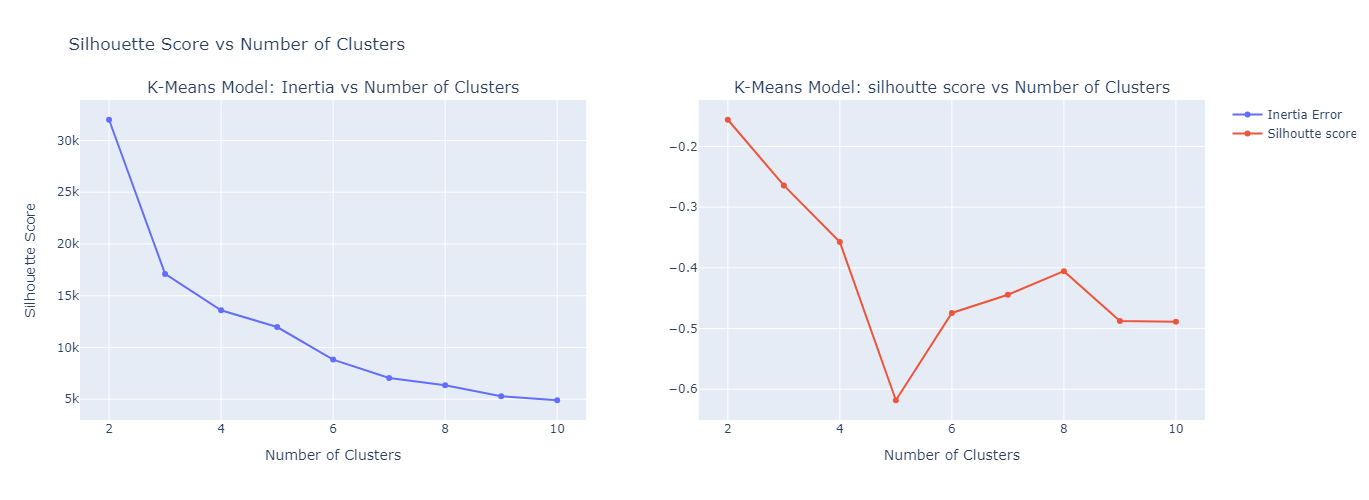

In [33]:
fig = make_subplots(rows=1, 
                    cols=2,
                    subplot_titles=("K-Means Model: Inertia vs Number of Clusters", 
                                    "K-Means Model: silhoutte score vs Number of Clusters"),
                    )

fig.add_trace(
    go.Line(x=score_df['cluster'], y=score_df['inertia_errors'], name="Inertia Error"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=score_df['cluster'], y=score_df['sil_score'],name="Silhoutte score"),
    row=1, col=2
)


# Update xaxis properties
fig.update_xaxes(title_text="Number of Clusters",row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2)
#fig.update_xaxes(title_text="Number of Clusters", row=1, col=3)


fig.update_layout(height=500, width=1200, title_text="Silhouette Score vs Number of Clusters",
                  yaxis_title="Silhouette Score")
fig.show()

## Choose Cluster = 4 and Visualize to see Result

In [35]:
kmeans_model = KMeans(featuresCol='scale',maxIter=30, k=4, seed=42).fit(cluster_df)
    
# silhoutte
pred = kmeans_model.transform(cluster_df)

In [36]:
evaluator = ClusteringEvaluator().evaluate(pred)
print(f'Silhoutte = {evaluator}')

Silhoutte = -0.35762398514664795


In [39]:
rfm_df = pred.toPandas()[['recency','frequency','monetary','rfm_score','prediction']]
rfm_df

,recency,frequency,monetary,rfm_score,prediction
0,325,1,77183.60,6,2
1,1,7,4310.00,12,1
2,74,4,1797.24,9,0
3,18,1,1757.55,9,0
4,309,1,334.40,4,2
...,...,...,...,...,...
5761,78,1,1.70,6,0
5762,323,1,29.43,5,2
5763,80,1,2653.95,9,0
5764,83,1,10.50,6,3


In [40]:
rfm_agg = rfm_df.groupby('prediction').agg({'recency':'mean','frequency':'mean','monetary':['mean','count']}).round(0)
rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['avg_recency', 'avg_freq', 'avg_monetary', 'count']
rfm_agg['percent'] = round((rfm_agg['count']/rfm_agg['count'].sum())*100,2)

# Reset index
rfm_agg = rfm_agg.reset_index()
rfm_agg

,prediction,avg_recency,avg_freq,avg_monetary,count,percent
0,0,50.0,2.0,855.0,1716,29.76
1,1,22.0,9.0,4676.0,1605,27.84
2,2,295.0,1.0,725.0,1244,21.57
3,3,152.0,1.0,660.0,1201,20.83


### Create Tree Map:

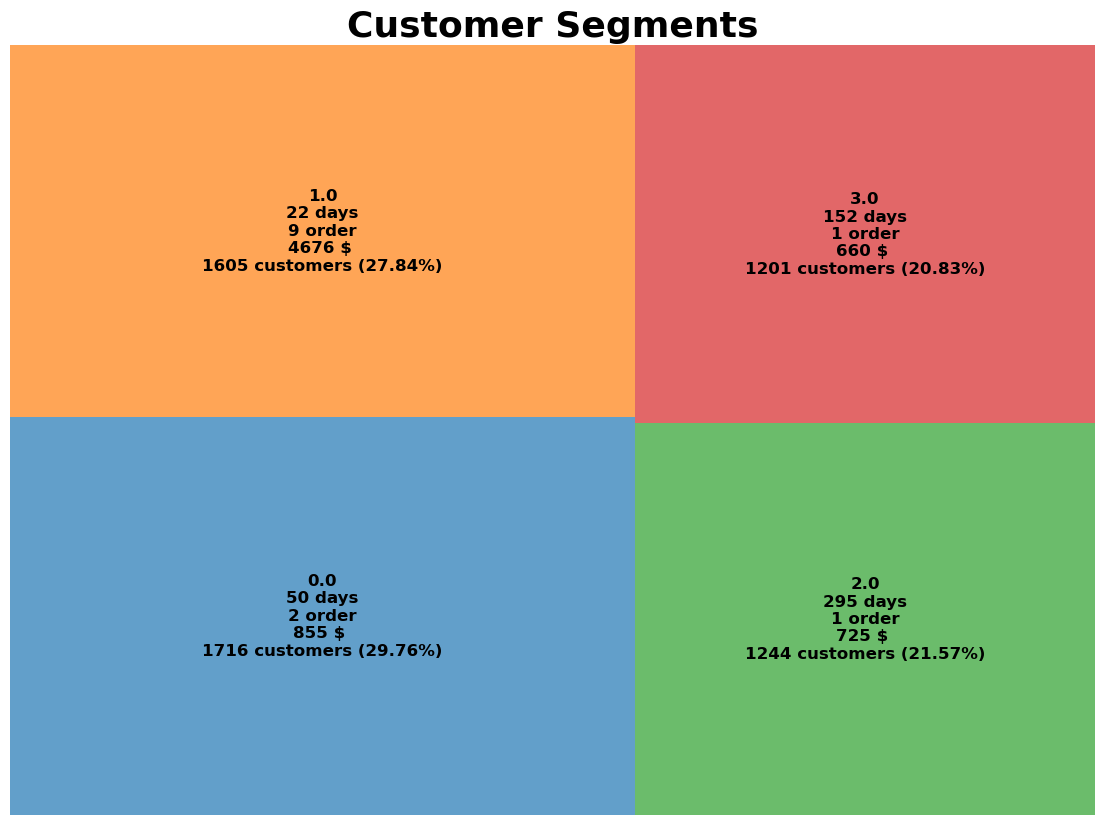

In [43]:
# Define label list
label_ls = ['{}\n{:.0f} days\n{:.0f} order\n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])  for i in range (0,len(rfm_agg))]

# Create tree map
figure = plt.gcf()
ax = figure.add_subplot()
figure.set_size_inches(14,10)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
squarify.plot(sizes=rfm_agg['count'],
              color=colors,
              text_kwargs={'fontsize':12, 'weight':'bold'}, 
              label=label_ls, 
              alpha=0.7)
plt.title("Customer Segments", fontsize=26, fontweight='bold')
plt.axis('off')
#plt.savefig('../Report/rfm_custom_group.png')
plt.show()

- It is kindly balance in 4 groups

### Create Scatter plot:

In [44]:
rfm_agg

,prediction,avg_recency,avg_freq,avg_monetary,count,percent
0,0,50.0,2.0,855.0,1716,29.76
1,1,22.0,9.0,4676.0,1605,27.84
2,2,295.0,1.0,725.0,1244,21.57
3,3,152.0,1.0,660.0,1201,20.83


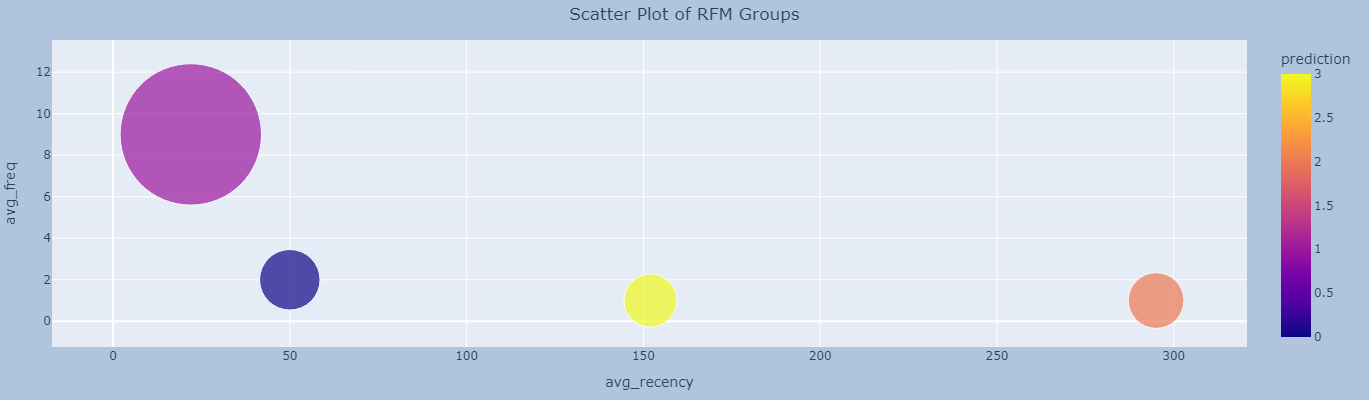

In [46]:
fig = px.scatter(rfm_agg, x='avg_recency', y ='avg_freq', size='avg_monetary',color='prediction', hover_name= 'prediction',hover_data=['percent'],size_max=100)

# Update layout
fig.update_layout(title_text="Scatter Plot of RFM Groups",
                  title_x=0.5,  # Set title text alignment to center
                  width=1200,  # Set width of the entire figure
                  height=400,  # Set height of the entire figure
                  margin=dict(l=40, r=40, t=40, b=40),  # Adjust margins
                  paper_bgcolor="LightSteelBlue",  # Set background color
                 )

fig.show()